In [48]:
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

import pandas as pd
import numpy as np
import cv2 as cv
import scipy as sp

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering, SpectralClustering, DBSCAN

import os
from collections import Counter
import warnings


In [4]:
warnings.filterwarnings('ignore')

In [5]:
def load_images(path: str, mode: str='RGB') -> np.ndarray:
    
    conversion_attr = f"COLOR_BGR2{mode}"
    conversion_code = getattr(cv, conversion_attr)
    
    images = []
    for file in os.listdir(path):
        if file.lower().endswith('.jpg'):
            img_path = os.path.join(path, file)
            img_bgr = cv.imread(img_path)
            if img_bgr is None:
                continue
            img = cv.cvtColor(img_bgr, conversion_code)
            images.append(img)
            
    return np.array(images)

# K-Means

In [6]:
def plot_multiple_Kmeans_analysis(data, reps: int=20, k_values=range(3, 10), mode: str='RGB'):

    all_pixels = data.reshape(-1, 3)
    kmeans_models = {k: KMeans(n_clusters=k, random_state=42).fit(all_pixels) for k in k_values}


    if mode != 'RGB':
        conversion_code = getattr(cv, f"COLOR_{mode}2RGB")
        
    used = list()

    dist_x = int((len(kmeans_models) + 1) * 1.8) # some fucking magic numbers there
    dist_y = int(reps * 2.2)
    fig, ax = plt.subplots(reps, len(kmeans_models) + 1, figsize=(dist_x, dist_y), dpi=100)

    for i in range(reps):
        
        num = np.random.randint(0, len(data))
        while num in used:
            num = np.random.randint(0, len(data))
        used.append(num)

        im = data[num]
        
        if mode != 'RGB':
            im = cv.cvtColor(im, conversion_code)
            
        ax[i, 0].imshow(im)
        ax[i, 0].axis('off')
        ax[i, 0].set_title(f'Original {num}')

        pixels = data[num].reshape(-1, 3)

        for idx, k in enumerate(k_values, start=1):
            model = kmeans_models[k]
            labels = model.predict(pixels)
            segmented_img = model.cluster_centers_[labels]
            segmented_img = segmented_img.reshape(data[num].shape)
            segmented_img = np.clip(segmented_img, 0, 255).astype(np.uint8)
            
            if mode != 'RGB':
                segmented_img = cv.cvtColor(segmented_img, conversion_code)

            ax[i, idx].imshow(segmented_img)
            ax[i, idx].axis('off')
            ax[i, idx].set_title(f'{k=} {mode=}')

    plt.tight_layout()

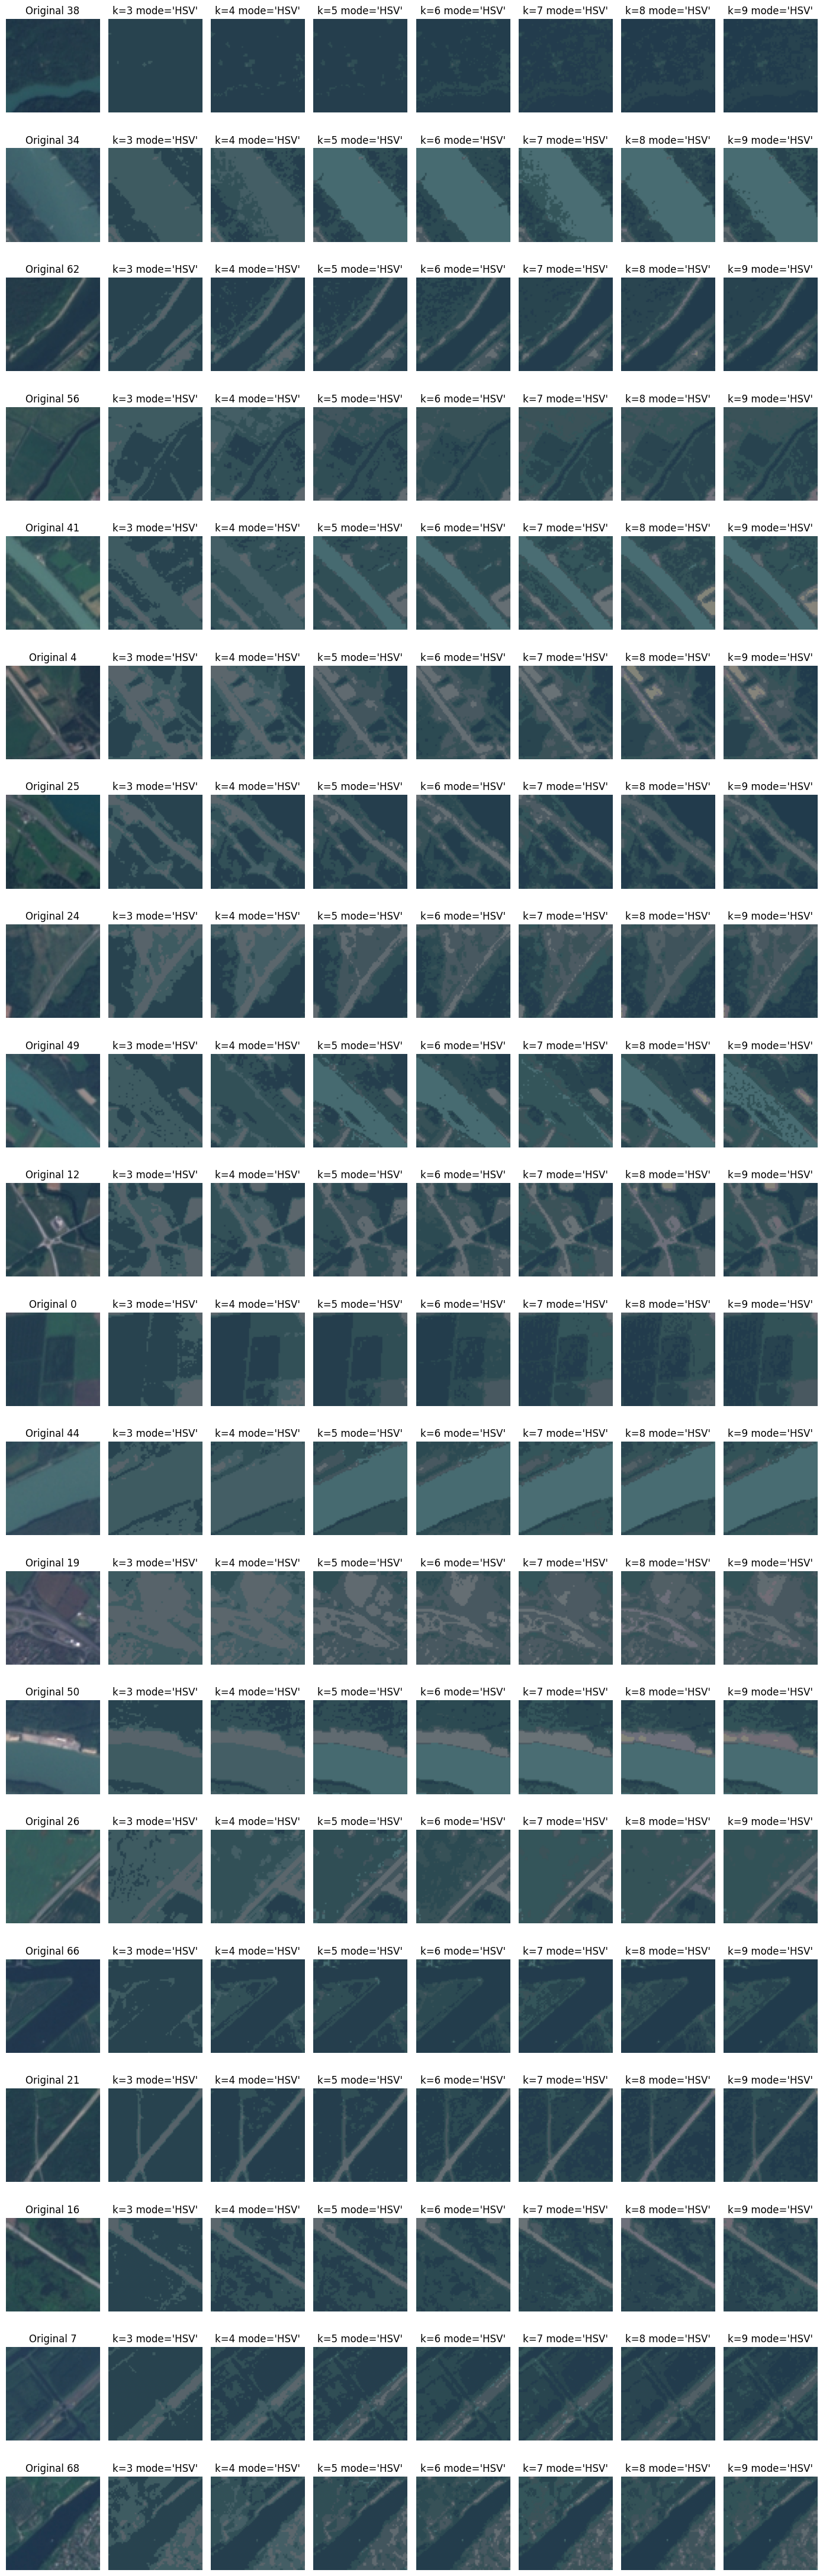

In [42]:
data = load_images(path='data/$learning_2', mode='HSV')
plot_multiple_Kmeans_analysis(data, reps=20, k_values=range(3,10), mode='HSV')

In [ ]:
def get_segmented_image(data, model, image_num, mode):
    
    pixels = data[image_num].reshape(-1, 3)
    labels = model.predict(pixels)
    
    if mode != 'RGB':
        conversion_code = getattr(cv, f"COLOR_{mode}2RGB")
        
    segmented_img = model.cluster_centers_[labels]
    segmented_img = segmented_img.reshape(data[image_num].shape)
    segmented_img = np.clip(segmented_img, 0, 255).astype(np.uint8)
    
    if mode != 'RGB':
        segmented_img = cv.cvtColor(segmented_img, conversion_code)
        
    return segmented_img, labels

In [ ]:
def plot_Kmeans_analysis(data, mode: str, image_num: int=None, k: int=4):
    
    if mode != 'RGB':
        conversion_code = getattr(cv, f"COLOR_{mode}2RGB")
    
    if image_num is None:
        image_num = np.random.randint(len(data))
    
    im = data[image_num]
    
    if mode != 'RGB':
        im = cv.cvtColor(im, conversion_code)
    
    model = KMeans(n_clusters=k, random_state=42, init='k-means++')
    model.fit(data.reshape(-1, 3))
    
    segmented_img, labels = get_segmented_image(data, model, image_num, mode)
    
    cluster_colors_rgb = []
    for color in model.cluster_centers_:
        color_img = color.reshape(1, 1, 3).astype(np.uint8)
        if mode != 'RGB':
            color_img = cv.cvtColor(color_img, conversion_code)
        cluster_colors_rgb.append(color_img[0, 0])
    
    cluster_colors_rgb = np.array(cluster_colors_rgb)

    if cluster_colors_rgb.max() <= 1.0:
        cluster_colors_rgb = (cluster_colors_rgb * 255)
    cluster_colors_rgb = cluster_colors_rgb.astype(np.uint8)

    hex_colors = [mcolors.to_hex(c / 255) for c in cluster_colors_rgb]
    palette = {str(i): hex_colors[i] for i in range(len(hex_colors))}

    fig, ax = plt.subplots(1, 3, figsize=(6,2))

    ax[0].imshow(im)
    ax[0].axis('off')
    ax[0].set_title(f'Original {image_num}')
    
    ax[1].imshow(segmented_img)
    ax[1].axis('off')
    ax[1].set_title(f'{mode=}  {k=}')

    sns.countplot(x=labels, palette=palette, ax=ax[2], order=[str(i) for i in range(k)])
    ax[2].set_title('Clusters size')
    ax[2].set_ylabel('')
    ax[2].tick_params(axis='y', labelsize=8)  
    box = ax[2].get_position()
    ax[2].set_position([box.x0, box.y0 + 0.047, box.width, box.height * 0.88]) # more magic numbers
    ticks = ax[2].get_yticks()
    ax[2].yaxis.tick_right()
    ax[2].set_yticks([ticks[-1]])
    ax[2].set_yticklabels([f'{int(ticks[-1])}'], fontsize=10)
    ax[2].set_xticks([])

presentable images: 12, 14
best configs: HSV + 5, 7; RGB + 4; Lab + 4;


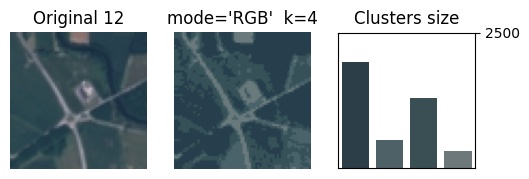

In [33]:
data = load_images('data/$learning_2', mode='RGB')
plot_Kmeans_analysis(data, mode='RGB', image_num=12, k=4)

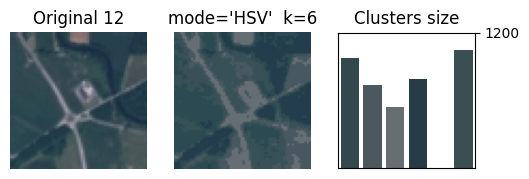

In [34]:
data = load_images('data/$learning_2', mode='HSV')
plot_Kmeans_analysis(data, mode='HSV', image_num=12, k=6)

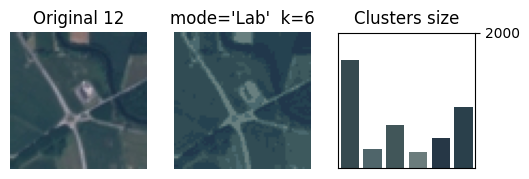

In [41]:
data = load_images('data/$learning_2', mode='Lab')
plot_Kmeans_analysis(data, mode='Lab', image_num=12, k=6)

# DBSCAN

Since DBSCAN method isnt provided with predict method, I have used [this](https://stackoverflow.com/questions/27822752/scikit-learn-predicting-new-points-with-dbscan) implementation